In [30]:
import numpy as np
import pandas as pd
import os 
import pickle
import sys
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import warnings

torch.set_printoptions(profile="full")
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings("ignore")

In [31]:
from src.attn import FixedPositionalEncoding, LearnablePositionalEncoding, TemporalEmbedding, MultiheadAttention, Decoder
from src.loss import ContrastiveLoss, FocalLoss

In [32]:
from datetime import datetime

In [33]:
seed = 777
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(seed)

In [34]:
path = '/data/notebook/shared/MIMIC-IV'

In [35]:
with open(os.path.join(path, 'dict_types_nomedi_mimic_240408_clinic_3_years.pkl'), 'rb') as f:
    dtype_dict = pickle.load(f)
f.close()

with open(os.path.join('./data', 'preprocessed_nomedi_240423_clinic_3_years.pkl'), 'rb') as f:
    data_dict_d = pickle.load(f)
f.close()

In [36]:
remain_year_clinical = pd.read_csv(os.path.join(path, "240408_remain_year_clinical_diag_seq_4.csv"))
del remain_year_clinical['clinical_label']

In [37]:
len(dtype_dict)

12702

In [38]:
labels = []
code_labels = []
length_list = []
clinical_labels = []
code_length_list = []
for sample_id, visits in tqdm(data_dict_d.items()):
    # 레이블 추가
    label = visits['label']
    code_label = visits['code_label']
    clinical_label = visits['clinical_label']
    labels.append(label)
    code_labels.append(code_label)
    clinical_labels.append(clinical_labels)

100%|██████████| 8037/8037 [00:00<00:00, 501422.34it/s]


In [39]:
train_indices, test_indices, train_y, test_y = train_test_split(list(data_dict_d.keys()), code_labels, test_size=0.1, random_state=777, stratify=code_labels)
train_indices, valid_indices, valid_y, valid_y = train_test_split(train_indices, train_y, test_size=(len(test_indices)/len(train_indices)), random_state=777, stratify=train_y) 

In [40]:
train_data = {}
valid_data = {}
test_data = {}
for sample in tqdm(train_indices):
    train_data[sample] = data_dict_d[sample]

for sample in tqdm(valid_indices):
    valid_data[sample] = data_dict_d[sample]

for sample in tqdm(test_indices):
    test_data[sample] = data_dict_d[sample]

100%|██████████| 804/804 [00:00<00:00, 1057122.39it/s]


In [41]:
train_clinical = remain_year_clinical[remain_year_clinical['subject_id'].isin(train_indices)].reset_index(drop=True)
valid_clinical = remain_year_clinical[remain_year_clinical['subject_id'].isin(valid_indices)].reset_index(drop=True)
test_clinical = remain_year_clinical[remain_year_clinical['subject_id'].isin(test_indices)].reset_index(drop=True)

In [42]:
class CustomDataset(Dataset):
    def __init__(self, data, clinical_df, scaler, mode='train'):       
        self.keys = list(data.keys())  # 딕셔너리의 키 목록 저장
        self.data = data  # 딕셔너리에서 데이터만 추출하여 저장
        self.scaler = scaler
        if mode == 'train':
            scaled_data = self.scaler.fit_transform(clinical_df.iloc[:, 2:])
            scaled_clinical_df = pd.DataFrame(scaled_data, columns = clinical_df.iloc[:, 2:].columns)
            self.scaled_clinical_df = pd.concat([clinical_df.iloc[:, :2], scaled_clinical_df], axis=1)
        else:
            scaled_data = self.scaler.transform(clinical_df.iloc[:, 2:])
            scaled_clinical_df = pd.DataFrame(scaled_data, columns = clinical_df.iloc[:, 2:].columns)
            self.scaled_clinical_df = pd.concat([clinical_df.iloc[:, :2], scaled_clinical_df], axis=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # x는 현재 방문까지의 모든 방문 데이터, y는 다음 방문 데이터
        padding_temp = torch.zeros((1, len(self.data[self.keys[idx]]['code_index'][0])), dtype=torch.long)
        
        origin_visit = torch.tensor(self.data[self.keys[idx]]['code_index'], dtype=torch.long)
        origin_mask = torch.tensor(self.data[self.keys[idx]]['seq_mask'], dtype=torch.long)
        origin_mask_final = torch.tensor(self.data[self.keys[idx]]['seq_mask_final'], dtype=torch.long)
        origin_mask_code = torch.tensor(self.data[self.keys[idx]]['seq_mask_code'], dtype=torch.long)
        
        next_visit = torch.cat((origin_visit[1:], padding_temp), dim=0)
        next_mask =torch.cat((origin_mask[1:], torch.tensor([0], dtype=torch.long)), dim=0)
        next_mask_code = torch.cat((origin_mask_code[1:], padding_temp), dim=0)
        
        clinical_data = self.scaled_clinical_df.loc[self.scaled_clinical_df['subject_id'] == self.keys[idx], self.scaled_clinical_df.columns[2:]].values
        clinical_data = torch.tensor(clinical_data, dtype=torch.float)
        visit_index = torch.tensor(self.data[self.keys[idx]]['year_onehot'], dtype=torch.long)
        last_visit_index = torch.tensor(self.data[self.keys[idx]]['last_year_onehot'], dtype=torch.float)
        time_feature = torch.tensor(self.data[self.keys[idx]]['time_feature'], dtype=torch.long)
        label_per_sample = self.data[self.keys[idx]]['code_label']
        key_per_sample = self.keys[idx]  # 해당 샘플의 키
        # 키 값도 함께 반환
        return {'sample_id': key_per_sample, 'origin_visit': origin_visit, 'next_visit': next_visit,\
                'origin_mask': origin_mask, 'origin_mask_final': origin_mask_final, 'next_mask': next_mask, \
                'origin_mask_code': origin_mask_code, 'next_mask_code': next_mask_code, 'time_feature': time_feature, \
                'clinical_data': clinical_data, 'visit_index': visit_index, 'last_visit_index': last_visit_index, \
                'label': label_per_sample}

In [43]:
scaler = StandardScaler()
train_dataset = CustomDataset(train_data, train_clinical, scaler, mode='train')
valid_dataset = CustomDataset(valid_data, valid_clinical, scaler, mode='valid')
test_dataset = CustomDataset(test_data, test_clinical, scaler, mode='test')

In [44]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [45]:
class CustomTransformerModel(nn.Module):
    def __init__(self, code_size, ninp, nhead, nhid, nlayers, dropout=0.5, device='cuda:0', pe='fixed'):
        super(CustomTransformerModel, self).__init__()
        self.ninp = ninp  # 축소된 차원 및 Transformer 입력 차원
        self.device = device
        # 차원 축소를 위한 선형 레이어
        self.pre_embedding = nn.Embedding(code_size, self.ninp)
        self.pe = pe
        if self.pe == 'fixed':
            self.pos_encoder = FixedPositionalEncoding(ninp, dropout)
        elif self.pe == 'time_feature':
            self.pos_encoder = TemporalEmbedding(ninp, embed_type='embed', dropout=dropout)
        else:
            self.pos_encoder = LearnablePositionalEncoding(ninp, dropout)
            
        self.transformer_decoder = Decoder(ninp, nhead, nhid, nlayers, dropout)
        self.decoder = nn.Linear(ninp, ninp, bias=False)  # 최종 출력 차원을 설정 (여기서는 ninp로 설정)
        self.classification_layer = nn.Linear(ninp, 2)
        self.clinical_transform = nn.Linear(18, ninp) 
        self.cross_attn = MultiheadAttention(ninp, nhead, dropout=0.3)
        self.init_weights()
        
    def init_weights(self):
        nn.init.xavier_uniform_(self.pre_embedding.weight)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.xavier_uniform_(self.classification_layer.weight)
    
    def forward(self, batch_data):
        # 차원 축소
        origin_visit = batch_data['origin_visit'].to(self.device)
        next_visit = batch_data['next_visit'].to(self.device)
        # clinical_tensor = batch_data['clinical_data'].to(self.device)
        mask_code = batch_data['origin_mask_code'].unsqueeze(3).to(self.device)
        next_mask_code = batch_data['next_mask_code'].unsqueeze(3).to(self.device)
        mask_final = batch_data['origin_mask_final'].unsqueeze(2).to(self.device)
        mask_final_year = batch_data['last_visit_index'].to(self.device)
                
        origin_visit_emb = (self.pre_embedding(origin_visit) * mask_code).sum(dim=2)
        next_visit_emb = (self.pre_embedding(next_visit) * next_mask_code).sum(dim=2)
        # 위치 인코딩 및 Transformer 디코더 적용
        if self.pe == 'time_feature':
            time_feature = batch_data['time_feature'].to(self.device)
            src = self.pos_encoder(origin_visit_emb, time_feature)
        else:
            src = self.pos_encoder(origin_visit_emb)
        
        seq_len = src.shape[1]
        src_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.uint8, device=self.device), diagonal=1)
        output = self.transformer_decoder(src, attention_mask=src_mask)
        output = self.decoder(output)
        
        output_batch, output_visit_num, output_dim = output.size()
        next_visit_output_batch, next_visit_output_num, next_visit_output_dim = next_visit_emb.size()
        
        # print(output[:, :torch.,:])
        temp_output = output.reshape(-1, output_dim)
        temp_next_visit = next_visit_emb.reshape(-1, next_visit_output_dim)
        final_visit = (output * mask_final).sum(dim=1)
        # year_emb = torch.bmm(output.transpose(1,2), mask_final_year).transpose(1,2)[:,:2,:]
        
        # transformed_clinical = self.clinical_transform(clinical_tensor)
        # mixed_output, mixed_cross_attn = self.cross_attn(year_emb, transformed_clinical, transformed_clinical)
        # mixed_output = mixed_output[:,-1,:]
        # mixed_final_emb = torch.cat((final_visit, mixed_output), dim=-1)
        classification_result = self.classification_layer(final_visit)    
        return temp_output, temp_next_visit, classification_result, final_visit

In [58]:
lr = 0.0005
ninp = 64
nhid = 256
nlayer = 3
gamma = 0.5
model_name = 'no_center_total_label_no_clinical'
pe = 'time_feature'

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = CustomTransformerModel(len(dtype_dict), ninp=ninp, nhead=4, nhid=nhid, nlayers=nlayer, dropout=0.1, device=device, pe=pe).to(device)
# model_2 = CustomTransformerModel(len(dtype_dict), ninp=ninp, nhead=8, nhid=nhid, nlayers=nlayer, dropout=0.6, device=device, pe='fixed').to(device)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr, weight_decay=1e-5)

# criterion = nn.BCEWithLogitsLoss()
criterion = FocalLoss(2, gamma=gamma)
# cosine_loss = CosineSimilarityLoss()
cosine_embedding_loss = nn.CosineEmbeddingLoss()
# const_loss = ContrastiveLoss(temperature=0.05)

In [49]:
# 얼리 스타핑 설정
num_epochs = 100
patience = 30
best_loss = float("inf")
counter = 0
epoch_temp = 0

best_f1 = 0.0
best_combined_score = 0.0
best_epoch = 0

view_total_loss = []
view_cos_loss = []
view_classi_loss = []

cos_lambda = 1
classi_lambda = 1
const_lambda = 1


for epoch in tqdm(range(num_epochs)):
    model_1.train()

    total_train_loss = 0
    total_cos_loss = 0
    total_classi_loss = 0
    total_const_loss = 0
    # key_per_sample, origin_visit, origin_mask, origin_mask_code, origin_mask_final, next_visit, next_mask, next_mask_code, next_mask_final, label_per_sample
    for batch_data in train_loader:
        tr_labels = batch_data['label'].to(device)
        optimizer.zero_grad()
        output_1, next_visit_output_1, final_visit_classification_1, final_visit_1 = model_1(batch_data)
        y = torch.ones(output_1.size(0), dtype=torch.float, device=device)
        y = y.to(device)   
        cosine_loss_mean_1 = cosine_embedding_loss(output_1, next_visit_output_1, y)
        classification_loss_1 = criterion(final_visit_classification_1.squeeze(), tr_labels.long())
        loss = (cos_lambda * cosine_loss_mean_1) + (classi_lambda * classification_loss_1)

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        total_cos_loss += (cosine_loss_mean_1.item())
        total_classi_loss += (classification_loss_1.item())
        # total_const_loss += train_const_loss.item()

        view_total_loss.append(total_train_loss)
        view_cos_loss.append(total_cos_loss)
        view_classi_loss.append(total_classi_loss)

    # 평균 손실 계산
    avg_train_loss = total_train_loss / len(train_loader)
    avg_cos_loss = total_cos_loss / len(train_loader)
    avg_classi_loss = total_classi_loss / len(train_loader)

    print("Epoch:", epoch+1, ", Total loss:", round(avg_train_loss, 4), ", cos_loss : ",\
          round(avg_cos_loss, 4), ", classification_loss :",round(avg_classi_loss, 4))

    model_1.eval()
    total_val_loss = 0
    total_val_cos_loss = 0
    total_val_classi_loss = 0
    total_val_const_loss = 0

    val_labels_list = []
    val_predictions_list = []
    val_probabilities_list = []


    with torch.no_grad():
        for batch_data in valid_loader:
            val_labels = batch_data['label'].to(device)
            val_output_1, val_next_visit_output_1, val_final_visit_classification_1, val_final_visit_1 = model_1(batch_data)
            
            y_val = torch.ones(val_output_1.size(0), dtype=torch.float, device=device) 
            val_cosine_loss_mean_1 = cosine_embedding_loss(val_output_1, val_next_visit_output_1, y_val)
            
            classification_loss_val_1 = criterion(val_final_visit_classification_1.squeeze(), val_labels.long())            

            val_loss = (cos_lambda * val_cosine_loss_mean_1) + (classi_lambda * classification_loss_val_1) 
            
            total_val_loss += val_loss.item()
            total_val_cos_loss += (val_cosine_loss_mean_1.item())
            total_val_classi_loss += (classification_loss_val_1.item())
            # total_val_const_loss += val_const_loss.item()

            val_probs = F.softmax(val_final_visit_classification_1)
            val_predictions = torch.max(val_probs, 1)[1].view((len(val_labels),))

            val_labels_list.extend(val_labels.view(-1).cpu().numpy())
            val_predictions_list.extend(val_predictions.cpu().numpy())
            
            ########
            val_probabilities_list.extend(val_probs[:,1].cpu().numpy())
            ######## 
            
            
        avg_val_loss = total_val_loss / len(valid_loader)
        avg_val_cos_loss = total_val_cos_loss / len(valid_loader)
        avg_val_classi_loss = total_val_classi_loss / len(valid_loader)

    # 성능 지표 계산
    accuracy = accuracy_score(val_labels_list, val_predictions_list)
    auc = roc_auc_score(val_labels_list, val_probabilities_list)
    f1 = f1_score(val_labels_list, val_predictions_list)
    precision = precision_score(val_labels_list,val_predictions_list)
    recall = recall_score(val_labels_list, val_predictions_list)

    print("Epoch:", epoch+1, ", valid loss:", round(avg_val_loss, 4), ", cos_loss : ",\
          round(avg_val_cos_loss, 4), ", classification_loss :",round(avg_val_classi_loss, 4))
    print("Accuracy:", round(accuracy,4), ", AUC: ", round(auc,4), ", F1: ", round(f1,4), ", Precision: ", round(precision,4), ", recall: ", round(recall,4))

    current_auc = roc_auc_score(val_labels_list, val_probabilities_list)
    current_f1 = f1_score(val_labels_list, val_predictions_list)
    current_combined_score = current_f1

    # 모델 저장 경로 설정
    model_save_path = f'results'
    date_dir = datetime.today().strftime("%Y%m%d")
    model_time =  datetime.today().strftime("%H%M%S")
    # 학습률과 분류 가중치를 파일명에 포함시키기 위한 문자열 포맷
    model_filename_format = f'model_lr{lr}_classi{classi_lambda}_dim{ninp}_hid{nhid}_layer{nlayer}_epoch{{epoch}}_{{model}}_{{pe}}_{{gamma}}_{model_time}.pth'

    # 모델 저장 폴더가 없으면 생성
    os.makedirs(os.path.join(model_save_path, date_dir), exist_ok=True)

    if current_combined_score > best_combined_score:
        best_combined_score = current_combined_score
        best_epoch = epoch
        counter = 0
        # 모델 저장 경로와 파일명을 결합하여 전체 파일 경로 생성
        model_1_save_path = os.path.join(model_save_path, date_dir, model_filename_format.format(epoch=best_epoch, model=model_name, pe=pe, gamma=gamma))
        # 모델 저장
        torch.save(model_1.state_dict(), f'{model_1_save_path}')
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered at epoch {}".format(best_epoch))
        print(f"Best Combined Score (AUC): {best_combined_score:.4f}")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 , Total loss: 1.8485 , cos_loss :  0.9826 , classification_loss : 0.8659


  1%|          | 1/100 [00:03<06:00,  3.64s/it]

Epoch: 1 , valid loss: 1.2361 , cos_loss :  0.96 , classification_loss : 0.2761
Accuracy: 0.9204 , AUC:  0.5986 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 2 , Total loss: 1.176 , cos_loss :  0.947 , classification_loss : 0.229


  2%|▏         | 2/100 [00:07<05:41,  3.48s/it]

Epoch: 2 , valid loss: 1.1512 , cos_loss :  0.9358 , classification_loss : 0.2154
Accuracy: 0.9204 , AUC:  0.6443 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 3 , Total loss: 1.1372 , cos_loss :  0.9299 , classification_loss : 0.2073


  3%|▎         | 3/100 [00:10<05:39,  3.50s/it]

Epoch: 3 , valid loss: 1.1176 , cos_loss :  0.9251 , classification_loss : 0.1925
Accuracy: 0.9204 , AUC:  0.6595 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 4 , Total loss: 1.1246 , cos_loss :  0.9225 , classification_loss : 0.2021


  4%|▍         | 4/100 [00:13<05:31,  3.45s/it]

Epoch: 4 , valid loss: 1.1101 , cos_loss :  0.9206 , classification_loss : 0.1896
Accuracy: 0.9204 , AUC:  0.6764 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 5 , Total loss: 1.1198 , cos_loss :  0.9191 , classification_loss : 0.2006


  5%|▌         | 5/100 [00:17<05:25,  3.43s/it]

Epoch: 5 , valid loss: 1.1101 , cos_loss :  0.9184 , classification_loss : 0.1917
Accuracy: 0.9204 , AUC:  0.7098 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 6 , Total loss: 1.1176 , cos_loss :  0.9173 , classification_loss : 0.2003


  6%|▌         | 6/100 [00:20<05:24,  3.45s/it]

Epoch: 6 , valid loss: 1.1087 , cos_loss :  0.9172 , classification_loss : 0.1915
Accuracy: 0.9204 , AUC:  0.7363 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 7 , Total loss: 1.115 , cos_loss :  0.9162 , classification_loss : 0.1988


  7%|▋         | 7/100 [00:24<05:18,  3.43s/it]

Epoch: 7 , valid loss: 1.1062 , cos_loss :  0.9164 , classification_loss : 0.1898
Accuracy: 0.9204 , AUC:  0.7715 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 8 , Total loss: 1.1126 , cos_loss :  0.9153 , classification_loss : 0.1973


  8%|▊         | 8/100 [00:27<05:17,  3.45s/it]

Epoch: 8 , valid loss: 1.1044 , cos_loss :  0.9158 , classification_loss : 0.1886
Accuracy: 0.9204 , AUC:  0.7732 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 9 , Total loss: 1.11 , cos_loss :  0.915 , classification_loss : 0.195


  9%|▉         | 9/100 [00:31<05:11,  3.43s/it]

Epoch: 9 , valid loss: 1.1026 , cos_loss :  0.9154 , classification_loss : 0.1872
Accuracy: 0.9204 , AUC:  0.7685 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 10 , Total loss: 1.1117 , cos_loss :  0.9148 , classification_loss : 0.1969


 10%|█         | 10/100 [00:34<05:07,  3.41s/it]

Epoch: 10 , valid loss: 1.1006 , cos_loss :  0.9152 , classification_loss : 0.1855
Accuracy: 0.9204 , AUC:  0.7727 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 11 , Total loss: 1.1083 , cos_loss :  0.9145 , classification_loss : 0.1939


 11%|█         | 11/100 [00:37<05:05,  3.44s/it]

Epoch: 11 , valid loss: 1.0982 , cos_loss :  0.9149 , classification_loss : 0.1833
Accuracy: 0.9204 , AUC:  0.7718 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 12 , Total loss: 1.1079 , cos_loss :  0.9143 , classification_loss : 0.1936


 12%|█▏        | 12/100 [00:41<05:00,  3.42s/it]

Epoch: 12 , valid loss: 1.0955 , cos_loss :  0.9148 , classification_loss : 0.1807
Accuracy: 0.9204 , AUC:  0.77 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 13 , Total loss: 1.1048 , cos_loss :  0.9142 , classification_loss : 0.1906


 13%|█▎        | 13/100 [00:44<04:59,  3.44s/it]

Epoch: 13 , valid loss: 1.0895 , cos_loss :  0.9148 , classification_loss : 0.1747
Accuracy: 0.9204 , AUC:  0.769 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 14 , Total loss: 1.0975 , cos_loss :  0.9144 , classification_loss : 0.1831


 14%|█▍        | 14/100 [00:48<04:54,  3.43s/it]

Epoch: 14 , valid loss: 1.079 , cos_loss :  0.915 , classification_loss : 0.164
Accuracy: 0.9204 , AUC:  0.7677 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 15 , Total loss: 1.0812 , cos_loss :  0.9147 , classification_loss : 0.1665


 15%|█▌        | 15/100 [00:51<04:52,  3.45s/it]

Epoch: 15 , valid loss: 1.0784 , cos_loss :  0.9161 , classification_loss : 0.1623
Accuracy: 0.9204 , AUC:  0.7299 , F1:  0.0 , Precision:  0.0 , recall:  0.0
Epoch: 16 , Total loss: 1.0688 , cos_loss :  0.9157 , classification_loss : 0.1531


 16%|█▌        | 16/100 [00:55<04:48,  3.43s/it]

Epoch: 16 , valid loss: 1.0443 , cos_loss :  0.9163 , classification_loss : 0.128
Accuracy: 0.954 , AUC:  0.7328 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 17 , Total loss: 1.0529 , cos_loss :  0.9157 , classification_loss : 0.1373


 17%|█▋        | 17/100 [00:58<04:44,  3.43s/it]

Epoch: 17 , valid loss: 1.0411 , cos_loss :  0.916 , classification_loss : 0.1251
Accuracy: 0.954 , AUC:  0.7655 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 18 , Total loss: 1.0529 , cos_loss :  0.9152 , classification_loss : 0.1377


 18%|█▊        | 18/100 [01:02<04:43,  3.46s/it]

Epoch: 18 , valid loss: 1.0405 , cos_loss :  0.9157 , classification_loss : 0.1249
Accuracy: 0.954 , AUC:  0.7703 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 19 , Total loss: 1.0518 , cos_loss :  0.915 , classification_loss : 0.1369


 19%|█▉        | 19/100 [01:05<04:38,  3.44s/it]

Epoch: 19 , valid loss: 1.0408 , cos_loss :  0.9157 , classification_loss : 0.1251
Accuracy: 0.954 , AUC:  0.7714 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 20 , Total loss: 1.0491 , cos_loss :  0.9147 , classification_loss : 0.1344


 20%|██        | 20/100 [01:08<04:36,  3.45s/it]

Epoch: 20 , valid loss: 1.0393 , cos_loss :  0.9156 , classification_loss : 0.1237
Accuracy: 0.954 , AUC:  0.7719 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 21 , Total loss: 1.0482 , cos_loss :  0.9149 , classification_loss : 0.1334


 21%|██        | 21/100 [01:12<04:35,  3.49s/it]

Epoch: 21 , valid loss: 1.0393 , cos_loss :  0.9155 , classification_loss : 0.1238
Accuracy: 0.954 , AUC:  0.772 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 22 , Total loss: 1.0474 , cos_loss :  0.9148 , classification_loss : 0.1326


 22%|██▏       | 22/100 [01:15<04:30,  3.47s/it]

Epoch: 22 , valid loss: 1.0432 , cos_loss :  0.9155 , classification_loss : 0.1277
Accuracy: 0.954 , AUC:  0.7699 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 23 , Total loss: 1.0497 , cos_loss :  0.9147 , classification_loss : 0.135


 23%|██▎       | 23/100 [01:19<04:27,  3.48s/it]

Epoch: 23 , valid loss: 1.0396 , cos_loss :  0.9153 , classification_loss : 0.1242
Accuracy: 0.954 , AUC:  0.7702 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 24 , Total loss: 1.0482 , cos_loss :  0.9144 , classification_loss : 0.1337


 24%|██▍       | 24/100 [01:23<04:29,  3.54s/it]

Epoch: 24 , valid loss: 1.0395 , cos_loss :  0.9153 , classification_loss : 0.1242
Accuracy: 0.954 , AUC:  0.7709 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 25 , Total loss: 1.049 , cos_loss :  0.9147 , classification_loss : 0.1344


 25%|██▌       | 25/100 [01:27<04:40,  3.74s/it]

Epoch: 25 , valid loss: 1.0388 , cos_loss :  0.9152 , classification_loss : 0.1236
Accuracy: 0.954 , AUC:  0.7713 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 26 , Total loss: 1.0496 , cos_loss :  0.9145 , classification_loss : 0.1351


 26%|██▌       | 26/100 [01:31<04:42,  3.82s/it]

Epoch: 26 , valid loss: 1.0397 , cos_loss :  0.9153 , classification_loss : 0.1245
Accuracy: 0.954 , AUC:  0.7694 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 27 , Total loss: 1.0474 , cos_loss :  0.9145 , classification_loss : 0.133


 27%|██▋       | 27/100 [01:35<04:43,  3.88s/it]

Epoch: 27 , valid loss: 1.0394 , cos_loss :  0.9152 , classification_loss : 0.1242
Accuracy: 0.954 , AUC:  0.769 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 28 , Total loss: 1.0521 , cos_loss :  0.9145 , classification_loss : 0.1376


 28%|██▊       | 28/100 [01:39<04:46,  3.98s/it]

Epoch: 28 , valid loss: 1.0398 , cos_loss :  0.9152 , classification_loss : 0.1246
Accuracy: 0.954 , AUC:  0.7705 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 29 , Total loss: 1.0495 , cos_loss :  0.9144 , classification_loss : 0.1351


 29%|██▉       | 29/100 [01:43<04:43,  3.99s/it]

Epoch: 29 , valid loss: 1.0464 , cos_loss :  0.9152 , classification_loss : 0.1312
Accuracy: 0.954 , AUC:  0.7712 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 30 , Total loss: 1.0489 , cos_loss :  0.9142 , classification_loss : 0.1347


 30%|███       | 30/100 [01:47<04:35,  3.94s/it]

Epoch: 30 , valid loss: 1.0395 , cos_loss :  0.9151 , classification_loss : 0.1244
Accuracy: 0.954 , AUC:  0.767 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 31 , Total loss: 1.0488 , cos_loss :  0.9143 , classification_loss : 0.1345


 31%|███       | 31/100 [01:50<04:20,  3.77s/it]

Epoch: 31 , valid loss: 1.0392 , cos_loss :  0.9151 , classification_loss : 0.1241
Accuracy: 0.954 , AUC:  0.7631 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 32 , Total loss: 1.0486 , cos_loss :  0.9144 , classification_loss : 0.1343


 32%|███▏      | 32/100 [01:54<04:08,  3.65s/it]

Epoch: 32 , valid loss: 1.0595 , cos_loss :  0.9152 , classification_loss : 0.1443
Accuracy: 0.954 , AUC:  0.7696 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 33 , Total loss: 1.0494 , cos_loss :  0.9148 , classification_loss : 0.1346


 33%|███▎      | 33/100 [01:57<04:01,  3.60s/it]

Epoch: 33 , valid loss: 1.0413 , cos_loss :  0.9154 , classification_loss : 0.1259
Accuracy: 0.954 , AUC:  0.7554 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 34 , Total loss: 1.0432 , cos_loss :  0.9148 , classification_loss : 0.1285


 34%|███▍      | 34/100 [02:00<03:53,  3.54s/it]

Epoch: 34 , valid loss: 1.0428 , cos_loss :  0.9155 , classification_loss : 0.1273
Accuracy: 0.954 , AUC:  0.7453 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 35 , Total loss: 1.0429 , cos_loss :  0.9149 , classification_loss : 0.1281


 35%|███▌      | 35/100 [02:04<03:48,  3.52s/it]

Epoch: 35 , valid loss: 1.0434 , cos_loss :  0.9158 , classification_loss : 0.1276
Accuracy: 0.954 , AUC:  0.7492 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 36 , Total loss: 1.0385 , cos_loss :  0.9152 , classification_loss : 0.1233


 36%|███▌      | 36/100 [02:07<03:43,  3.50s/it]

Epoch: 36 , valid loss: 1.048 , cos_loss :  0.9163 , classification_loss : 0.1318
Accuracy: 0.954 , AUC:  0.7507 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 37 , Total loss: 1.0328 , cos_loss :  0.9158 , classification_loss : 0.117


 37%|███▋      | 37/100 [02:11<03:40,  3.49s/it]

Epoch: 37 , valid loss: 1.059 , cos_loss :  0.9167 , classification_loss : 0.1423
Accuracy: 0.944 , AUC:  0.7583 , F1:  0.5631 , Precision:  0.7436 , recall:  0.4531
Epoch: 38 , Total loss: 1.0253 , cos_loss :  0.9162 , classification_loss : 0.1091


 38%|███▊      | 38/100 [02:14<03:38,  3.52s/it]

Epoch: 38 , valid loss: 1.0598 , cos_loss :  0.9176 , classification_loss : 0.1422
Accuracy: 0.949 , AUC:  0.763 , F1:  0.5859 , Precision:  0.8286 , recall:  0.4531
Epoch: 39 , Total loss: 1.0204 , cos_loss :  0.9171 , classification_loss : 0.1033


 39%|███▉      | 39/100 [02:18<03:34,  3.51s/it]

Epoch: 39 , valid loss: 1.0738 , cos_loss :  0.9182 , classification_loss : 0.1556
Accuracy: 0.9328 , AUC:  0.7713 , F1:  0.5179 , Precision:  0.6042 , recall:  0.4531
Epoch: 40 , Total loss: 1.0114 , cos_loss :  0.9173 , classification_loss : 0.094


 40%|████      | 40/100 [02:22<03:32,  3.54s/it]

Epoch: 40 , valid loss: 1.085 , cos_loss :  0.9186 , classification_loss : 0.1664
Accuracy: 0.9204 , AUC:  0.7538 , F1:  0.4754 , Precision:  0.5 , recall:  0.4531
Epoch: 41 , Total loss: 1.0081 , cos_loss :  0.9177 , classification_loss : 0.0904


 41%|████      | 41/100 [02:25<03:28,  3.53s/it]

Epoch: 41 , valid loss: 1.0819 , cos_loss :  0.9195 , classification_loss : 0.1624
Accuracy: 0.954 , AUC:  0.7541 , F1:  0.5934 , Precision:  1.0 , recall:  0.4219
Epoch: 42 , Total loss: 0.9976 , cos_loss :  0.9184 , classification_loss : 0.0792


 42%|████▏     | 42/100 [02:28<03:22,  3.50s/it]

Epoch: 42 , valid loss: 1.0762 , cos_loss :  0.9199 , classification_loss : 0.1564
Accuracy: 0.9428 , AUC:  0.7811 , F1:  0.54 , Precision:  0.75 , recall:  0.4219
Epoch: 43 , Total loss: 0.9881 , cos_loss :  0.9188 , classification_loss : 0.0693


 43%|████▎     | 43/100 [02:32<03:19,  3.51s/it]

Epoch: 43 , valid loss: 1.0731 , cos_loss :  0.9199 , classification_loss : 0.1532
Accuracy: 0.9465 , AUC:  0.7365 , F1:  0.5657 , Precision:  0.8 , recall:  0.4375
Epoch: 44 , Total loss: 0.9803 , cos_loss :  0.9189 , classification_loss : 0.0614


 44%|████▍     | 44/100 [02:35<03:14,  3.48s/it]

Epoch: 44 , valid loss: 1.0766 , cos_loss :  0.9204 , classification_loss : 0.1562
Accuracy: 0.944 , AUC:  0.7727 , F1:  0.5631 , Precision:  0.7436 , recall:  0.4531
Epoch: 45 , Total loss: 0.973 , cos_loss :  0.9193 , classification_loss : 0.0537


 45%|████▌     | 45/100 [02:39<03:11,  3.48s/it]

Epoch: 45 , valid loss: 1.0906 , cos_loss :  0.9206 , classification_loss : 0.17
Accuracy: 0.9428 , AUC:  0.7519 , F1:  0.566 , Precision:  0.7143 , recall:  0.4688
Epoch: 46 , Total loss: 0.9729 , cos_loss :  0.9196 , classification_loss : 0.0533


 45%|████▌     | 45/100 [02:42<03:18,  3.62s/it]

Epoch: 46 , valid loss: 1.0673 , cos_loss :  0.9206 , classification_loss : 0.1466
Accuracy: 0.9453 , AUC:  0.774 , F1:  0.551 , Precision:  0.7941 , recall:  0.4219
Early stopping triggered at epoch 15
Best Combined Score (AUC): 0.5934


In [79]:
total_te_loss = 0
total_te_cos_loss = 0
total_te_classi_loss = 0
total_te_const_loss = 0

te_labels_list = []
te_predictions_list = []
te_probabilities_list = []

model_1_path = model_1_save_path

model_1.load_state_dict(torch.load(model_1_path))

model_1.eval()

with torch.no_grad():
    for batch_idx, batch_data in enumerate(tqdm(test_loader)):
        te_labels = batch_data['label'].to(device)
        te_output_1, te_next_visit_output_1, te_final_visit_classification_1, te_final_visit_1 = model_1(batch_data)
        y_te = torch.ones(te_output_1.size(0), dtype=torch.float, device=device)
        
        if batch_idx == 0:
            test_visit_embedding = te_final_visit_1.detach().cpu().numpy()
            test_label_numpy = te_labels.detach().cpu().numpy()
        else:
            add_visit_embedding = te_final_visit_1.detach().cpu().numpy()
            add_label_numpy = te_labels.detach().cpu().numpy()
            test_visit_embedding = np.concatenate((test_visit_embedding, add_visit_embedding), axis=0)
            test_label_numpy = np.concatenate((test_label_numpy, add_label_numpy))

        te_cosine_loss_mean_1 = cosine_embedding_loss(te_output_1, te_next_visit_output_1, y_te)
        classification_loss_te_1 = criterion(te_final_visit_classification_1.squeeze(), te_labels.long())
        te_loss = (cos_lambda * te_cosine_loss_mean_1) + (classi_lambda * classification_loss_te_1) 

        total_te_loss += te_loss.item()
        total_te_cos_loss += (te_cosine_loss_mean_1.item())
        total_te_classi_loss += (classification_loss_te_1.item())

        te_probs = F.softmax(te_final_visit_classification_1)
        te_predictions = torch.max(te_probs, 1)[1].view((len(te_labels),))
        
        te_labels_list.extend(te_labels.view(-1).cpu().numpy())
        te_predictions_list.extend(te_predictions.cpu().numpy())
        te_probabilities_list.extend(te_probs[:,1].cpu().numpy())

    avg_te_loss = total_te_loss / len(test_loader)
    avg_te_cos_loss = total_te_cos_loss / len(test_loader)
    avg_te_classi_loss = total_te_classi_loss / len(test_loader)

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


In [53]:
## 성능 지표 계산
accuracy = accuracy_score(te_labels_list, te_predictions_list)
auc = roc_auc_score(te_labels_list, te_probabilities_list)
f1 = f1_score(te_labels_list, te_predictions_list)
precision = precision_score(te_labels_list,te_predictions_list)
recall = recall_score(te_labels_list, te_predictions_list)

print("test loss:", round(avg_te_loss, 4), ", cos_loss : ", round(avg_te_cos_loss, 4),
      ", classification_loss :",round(avg_te_classi_loss, 4), 
      # ", contrastive_loss : ", round(avg_te_const_loss,4)
     )
print("Accuracy:", round(accuracy,4), ", AUC: ", round(auc,4), ", F1: ", round(f1,4), ", Precision: ", round(precision,4), ", recall: ", round(recall,4))

np.unique(te_labels_list,  return_counts=True)

test loss: 1.0603 , cos_loss :  0.9183 , classification_loss : 0.142
Accuracy: 0.9502 , AUC:  0.7388 , F1:  0.5455 , Precision:  1.0 , recall:  0.375


(array([0, 1]), array([740,  64]))

In [55]:
log_path = './logs'
logs = f'model_lr{lr}_classi{classi_lambda}_dim{ninp}_hid{nhid}_layer{nlayer}_epoch{{epoch}}_{{model}}_{{pe}}_{model_time}.txt'
os.makedirs(os.path.join(log_path, date_dir), exist_ok=True)

results = [accuracy, auc, f1, precision, recall]
cm = confusion_matrix(te_labels_list, te_predictions_list)
with open(os.path.join(log_path, date_dir, logs.format(epoch=best_epoch, model=model_name, pe=pe)), 'w') as f:
    f.write(logs.format(epoch=best_epoch, model=model_name, pe=pe))
    f.write('\n')
    f.write(str(results))
    f.write('\n')
    f.write(str(cm))

In [56]:
confusion_matrix(te_labels_list, te_predictions_list)

array([[740,   0],
       [ 40,  24]])

In [82]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_model = TSNE(n_components=2)
reduction_emb = tsne_model.fit_transform(test_visit_embedding)

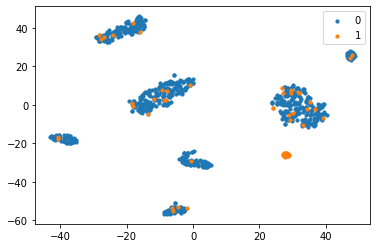

In [90]:
fig, ax = plt.subplots()
for g in np.unique(test_label_numpy):
    ix = np.where(test_label_numpy == g)
    ax.scatter(reduction_emb[ix, 0], reduction_emb[ix, 1], label = g, s = 10)
ax.legend()
plt.show()